In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import rGI0, partitioned_gi0_image
from scripts.autoencoders import InMemoryImageDataset, generate_multiple_images, Autoencoder

import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

---
### Empiezo graficando algunos ejemplos de imagenes

In [2]:
g, gi, gI0 = rGI0(n=100*100, p_alpha=-1.5, p_gamma=1, p_Looks=1)

In [3]:
g = g.reshape(100, 100)
gi = gi.reshape(100, 100)
gI0 = gI0.reshape(100, 100)

Text(0.5, 1.0, 'Ruido speckle ~ Gamma')

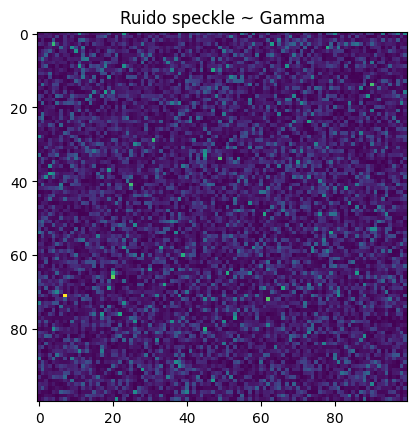

In [4]:
plt.imshow(g)
plt.title('Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Backscatter ~ Gamma inversa')

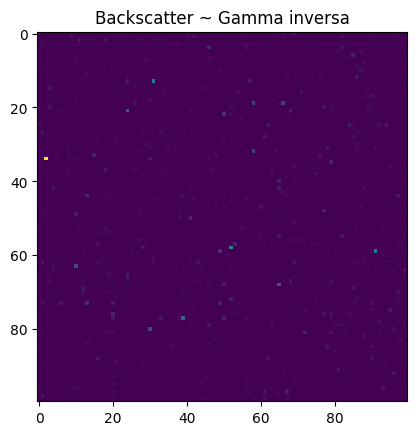

In [5]:
plt.imshow(gi)
plt.title('Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen + ruido speckle ~ GI0')

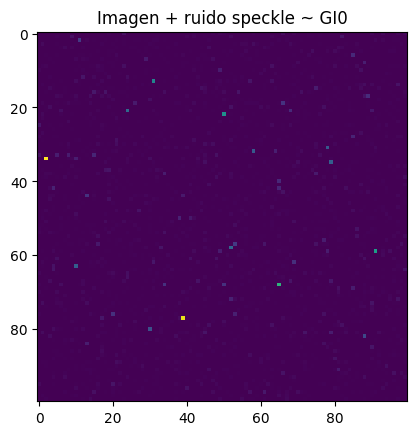

In [6]:
plt.imshow(gI0)
plt.title('Imagen + ruido speckle ~ GI0')

In [7]:
imagen_g, imagen_gi, imagen_gI0 = partitioned_gi0_image(
    p_alphas=[-1.5,-5,-1.7,-10],
    p_gammas=[1,1,1,1],
    p_looks=[1,1,1,1]
)

Text(0.5, 1.0, 'Imagen particionada - Ruido speckle ~ Gamma')

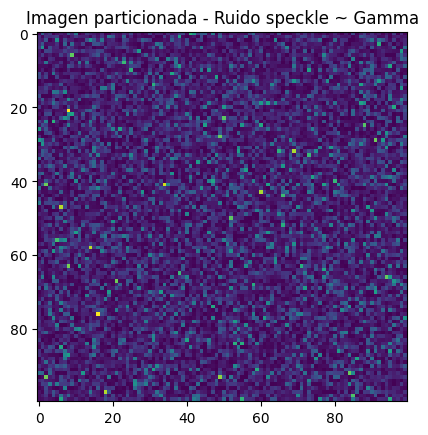

In [8]:
plt.imshow(imagen_g)
plt.title('Imagen particionada - Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Imagen particionada - Backscatter ~ Gamma inversa')

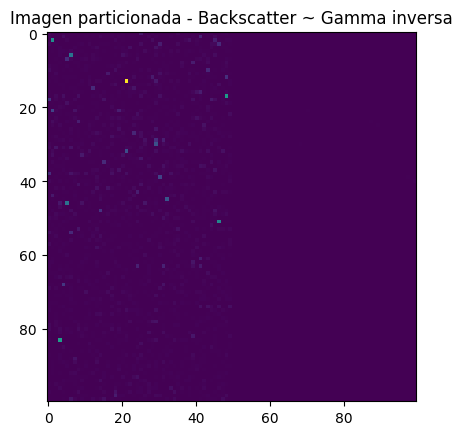

In [9]:
plt.imshow(imagen_gi)
plt.title('Imagen particionada - Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen particionada - Imagen + ruido speckle ~ GI0')

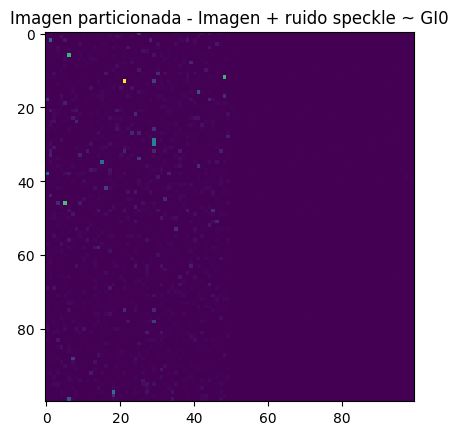

In [10]:
plt.imshow(imagen_gI0)
plt.title('Imagen particionada - Imagen + ruido speckle ~ GI0')

---
### Genero un dataset para entrenar

In [11]:
n = 1000
train_g, train_gi, train_gI0 = generate_multiple_images(n, partitioned_gi0_image)

In [12]:
batch_size = 32

In [20]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [21]:
entrada_red, salida_red = dataset_train[21]

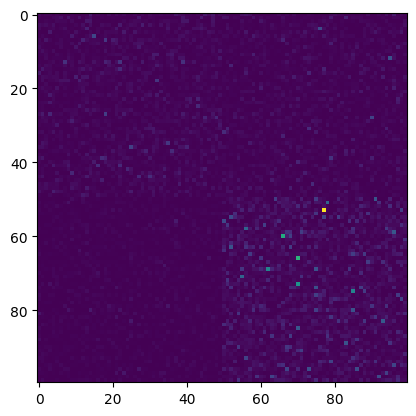

In [22]:
plt.imshow(entrada_red[0,:,:])

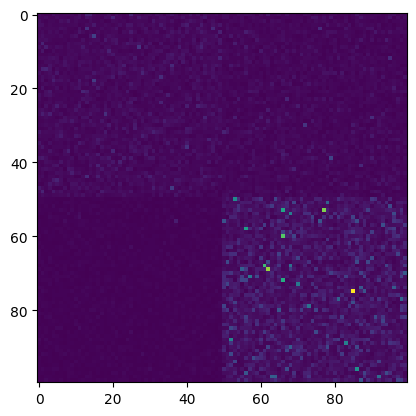

In [23]:
plt.imshow(salida_red[0,:,:])

---
### Entreno

In [24]:
encoding_dim = 32
learning_rate = 1e-3
num_epochs = 10

In [25]:
autoencoder = Autoencoder(encoding_dim)
criterion = nn.BCELoss() # Utilizamos Binary Cross Entropy Loss como loss function ya que las imágenes están normalizadas en el rango [0, 1]
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # El optimizador es responsable de ajustar los pesos del modelo con el fin de minimizar la función de pérdida.
                                                                   # Adam es un algoritmo de optimización popular y eficiente que adapta la tasa de aprendizaje de forma dinámica para cada parámetro del modelo.
                                                                   # La tasa de aprendizaje determina qué tan rápido se ajustan los pesos del modelo durante el entrenamiento.


In [26]:
for epoch in range(num_epochs):
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.view(entrada.size(0), -1).float()
        salida = salida.view(salida.size(0), -1).float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.2214
Epoch [2/10], Loss: 0.3001
Epoch [3/10], Loss: 0.1348
Epoch [4/10], Loss: 0.0796
Epoch [5/10], Loss: 0.0952
Epoch [6/10], Loss: 0.1156
Epoch [7/10], Loss: 0.1306
Epoch [8/10], Loss: 0.0352
Epoch [9/10], Loss: 0.0781
Epoch [10/10], Loss: 0.1160
